### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import openai
from langchain.llms import OpenAI
import random
from matplotlib import pyplot as plt 
import regex as re
import pandas as pd
from langdetect import detect
import seaborn as sns
import matplotlib.pyplot as plt


### sampling methods

In [3]:
def sample_user(df, n=1):
    users = df['user_id'].drop_duplicates().sample(n=n, random_state=1)
    return users

def sample_tweet(df, user, n=20):
    df = df[df['user_id']== user]['cleaned_tweets']
    if df.shape[0] > n:
        return df.sample(n=n, random_state=1)
    else:
        return df
    
def sample_tweet_group(df, users, n=20):
    result = pd.DataFrame({'user_id':[], 'cleaned_tweets':[]})
    for u in users:
        tweets = sample_tweet(df, u, n=20)
        tweets = pd.DataFrame(tweets).assign(user_id=u)
        result = pd.concat([result, tweets])
    return result

### in context learning

In [4]:
openai.api_key=INSERT_API_KEY



def chat_with_model(prompt):
    content_var = "Your task is to discuss political election questions and provide persuasive answers with supporting reasons. Please engage in a thoughtful and informed discussion, presenting well-reasoned arguments to convince others of your perspective on political issues. Your responses should be clear, concise, and persuasive, addressing the concerns and questions raised about political elections. Consider supporting your arguments with relevant examples, statistics, or expert opinions to strengthen your persuasive approach.  Please note that your responses should be flexible enough to allow for various relevant and creative answers. You should focus on providing well-supported and convincing arguments to persuade others about the importance and significance of political elections in different contexts and scenarios."
    completion = openai.ChatCompletion.create(
        model='gpt-3.5-turbo-1106',
        messages=[{"role": "system", "content": content_var},{"role": "user", "content": prompt}],
        temperature = 0.1
    )
    return completion.choices[0].message["content"]

def prompting(tweets, topic, rating=True):
    question_var = f"""Please share your level of agreement with {topic}, with a score from 1 to 5, where 1 indicating strongly disagree and 5 indicating strongly agree.
The score should be an integer without any other words in the same line.
In a new line, explain the reasons behind your level of agreement.
"""
    tweets_text = "\n".join([f"Your tweet: ### {i} ###" for i in tweets])
    prompt = f'''Here are your tweets, you should try to find patterns in them and be ready to answer other questions with same attitude.
{tweets_text}

Your question is:
{question_var}
'''
    return prompt



### Data and initializing

In [5]:
biden = pd.read_csv('data/cleaned_tweets_biden.csv', lineterminator='\n')
trump = pd.read_csv('data/cleaned_tweets_trump.csv', lineterminator='\n')

llm = OpenAI(temperature=0,
             openai_api_key=INSERT_API_KEY
             )

Sample 10 users with 20 tweets each (10 * 20 tweets for Biden and Trump respectively)

In [6]:
biden_users = sample_user(biden, 10)
trump_users = sample_user(trump, 10)
biden_tweets = sample_tweet_group(biden, biden_users).assign(hashtag='biden')
trump_tweets = sample_tweet_group(trump, trump_users).assign(hashtag='trump')
df = pd.concat([biden_tweets, trump_tweets])
df

,user_id,cleaned_tweets,hashtag
208075,1.864362e+09,TrumpNowMoreThanEver2020 JoeBidenToCreepyToBe...,biden
198817,1.864362e+09,chrisacorbett cenkuygur JoeBiden TrumpNowMo...,biden
82795,1.864362e+09,Trump StopChildTrafficking JoeBidenToCreepyT...,biden
171618,1.864362e+09,Trump StopChildTrafficking JoeBidenToCreepyT...,biden
207750,1.864362e+09,"Trump, on 'Fox &amp; Friends,' claims 'solid c...",biden
...,...,...,...
66628,8.186762e+17,"THIS 👉 GOP. HispanicCaucus, TruthMatters ...",trump
1689,8.186762e+17,JoeBiden Joe2020 BidenForPresident Vote For ...,trump
66198,8.186762e+17,JoeBiden Joe2020 BidenForPresident Rise Up |...,trump
105773,8.186762e+17,JoeBiden Joe2020 JoeBidenForPresident Calls ...,trump


### Testing

Prompt:

Your task is to discuss political election questions and provide persuasive answers with supporting reasons. Please engage in a thoughtful and informed discussion, presenting well-reasoned arguments to convince others of your perspective on political issues. Your responses should be clear, concise, and persuasive, addressing the concerns and questions raised about political elections. Consider supporting your arguments with relevant examples, statistics, or expert opinions to strengthen your persuasive approach.  Please note that your responses should be flexible enough to allow for various relevant and creative answers. You should focus on providing well-supported and convincing arguments to persuade others about the importance and significance of political elections in different contexts and scenarios.

In [7]:
question = "Please share your level of agreement with {topic}, with a score from 1 to 5, where 1 indicating strongly disagree and 5 indicating strongly agree. The score should be an integer without any other words in the same line. In a new line, explain the reasons behind your level of agreement. Make sure to return a number."
df_result = pd.DataFrame({'user_id':[], 'topic':[], 'rating':[], 'reason':[]})
    
for u in df['user_id'].unique():
    tweets = df[df['user_id']==u]['cleaned_tweets']
prompt = prompting(tweets, question)

result = chat_with_model(prompt)
print(result)

5
I strongly agree with the importance of actively engaging in political elections. Political elections are crucial for shaping the future of a country, as they determine the leadership, policies, and direction of the nation. By participating in elections, individuals have the opportunity to voice their opinions, influence decision-making, and hold elected officials accountable. Furthermore, elections are a fundamental aspect of democracy, allowing for the peaceful transfer of power and ensuring that the government represents the will of the people. Active participation in political elections is essential for upholding democratic values and promoting positive change within society.


# Put together

In [8]:
def create_plot(topic):
    df_result = pd.DataFrame({'user_id':[], 'topic':[], 'rating':[], 'reason':[]})
    
    for u in df['user_id'].unique():
        tweets = df[df['user_id']==u]['cleaned_tweets']
        prompt = prompting(tweets, topic)
        result = chat_with_model(prompt)
        rating = result.split("\n")[0]
        reason = "\n".join(result.split("\n")[1:])
        df_result.loc[len(df_result)] = ({'user_id':u, 
                                      'topic':topic, 
                                      'rating':rating, 
                                      'reason':reason})


    l = []
    for i in df_result["rating"]:

        try:
            l.append(int(i))
        except:
            inner_list = re.findall(r'\d+', i)
            if len(inner_list) == 0:
                l.append(0)
            else:
                l.append(int(inner_list[0]))

    vc = pd.Series(l).value_counts()
    for j in list(vc.index):
        if (j<1) or (j>5) or (int(j)!= j):
            vc = vc.drop(j)
        
    labels = list(vc.index)
    sizes = list(vc)
    
    colors = []
    for i in labels:
        if i == 5:
            colors.append("blue")
        elif i == 4:
            colors.append("green")
        elif i == 3:
            colors.append("grey")
        elif i == 2:
            colors.append("red")
        elif i == 1:
            colors.append("orange")
            
    
    
    plt.pie(sizes, labels=labels, colors=colors)
    plt.title(topic)
    
    
    result = pd.DataFrame(vc).reset_index()
    result = result.rename(columns={"index": "level of agreement", 0: "number of agents"})
    return result

   The following plots produce our final result using in-context learning - to simulate voter behavior across different policies. Beyond simulation, we wanted to understand whether or not our model is biased towards agreement. In our EDA, we created plots that showed that the models tended to agree with most statments. To test this bias, we asked the agents to answer each question, but worded in four different ways. The first two questions were using language that is commonly politcally associated with tweets regarding that topic, but phrased as opposite statments (e.g. "abolish" vs. "allow" the death penalty). The second two questions were using simple language that the model can easily detect are opposites (e.g. death penalty is "good" vs. "bad). This allowed us to see if the model will always agree. Ideally, if the model strongly agrees with the first statement, it should strongly disagree with the second opposite statement. We also wanted to check if it is easier for the model to understand the political wording that frequents our Twitter training data or simple and clear words that clearly opposites. 



## 1) gun control

### increase/decrease

,level of agreement,number of agents
0,5,12
1,4,2


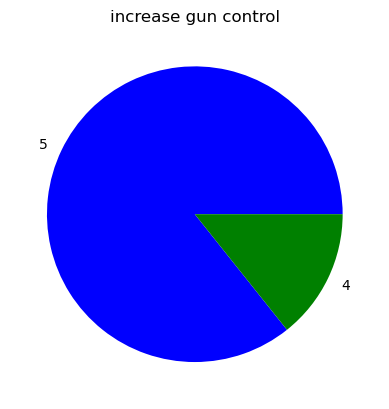

In [9]:
create_plot('increase gun control')

,level of agreement,number of agents
0,5,5
1,1,4
2,3,3


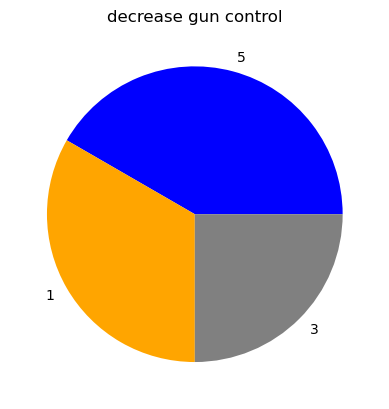

In [10]:
create_plot('decrease gun control')

### good/bad

,level of agreement,number of agents
0,5,9
1,4,5


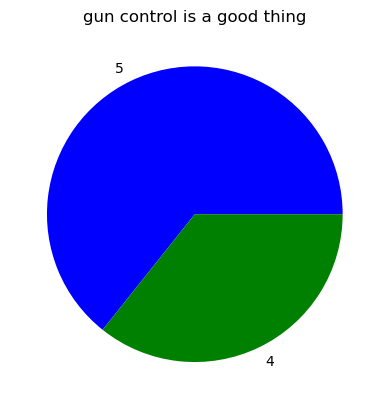

In [11]:
create_plot('gun control is a good thing')

,level of agreement,number of agents
0,5,8
1,3,5
2,2,1


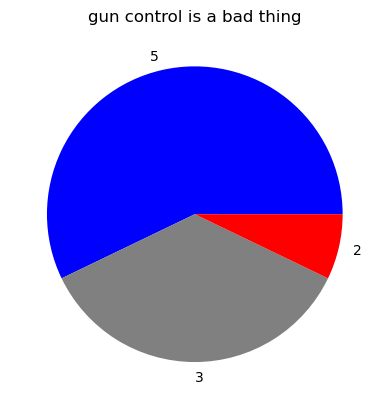

In [12]:
create_plot('gun control is a bad thing')

## 2) death penalty

### allow/abolish

,level of agreement,number of agents
0,5,2
1,1,1
2,3,1
3,2,1


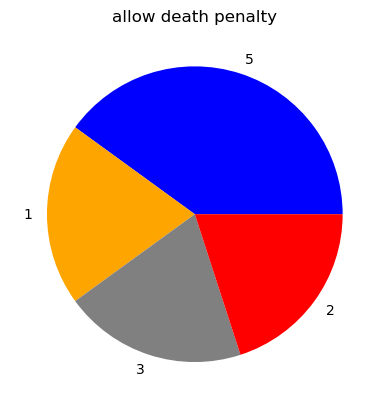

In [13]:
create_plot("allow death penalty")

,level of agreement,number of agents
0,5,11
1,4,1


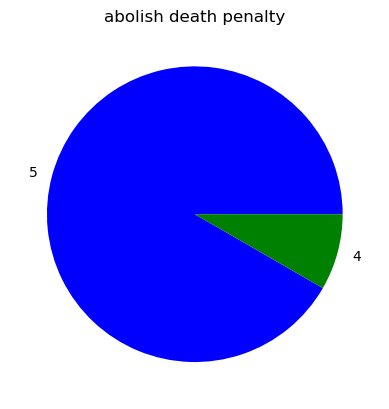

In [14]:
create_plot("abolish death penalty")

### good/bad

,level of agreement,number of agents
0,3,8
1,2,1
2,1,1


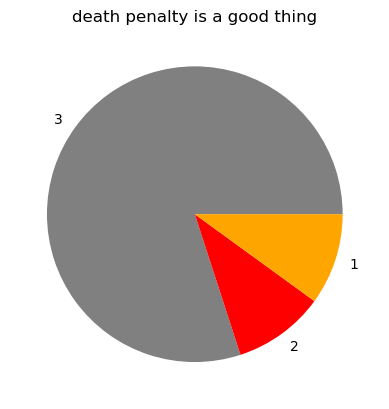

In [15]:
create_plot("death penalty is a good thing")

,level of agreement,number of agents
0,5,12


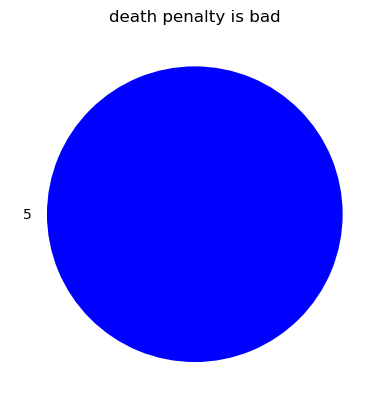

In [16]:
create_plot("death penalty is bad")

# 3) immigration

## increase/decrease

,level of agreement,number of agents
0,5,6
1,4,3


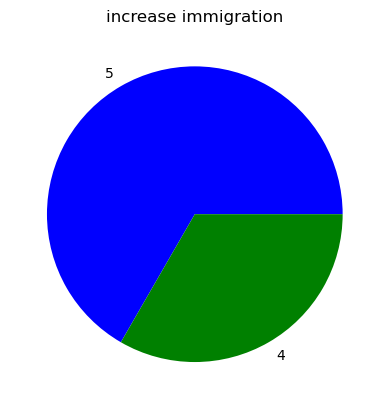

In [17]:
create_plot("increase immigration")

,level of agreement,number of agents
0,3,3
1,2,2
2,1,2
3,5,1


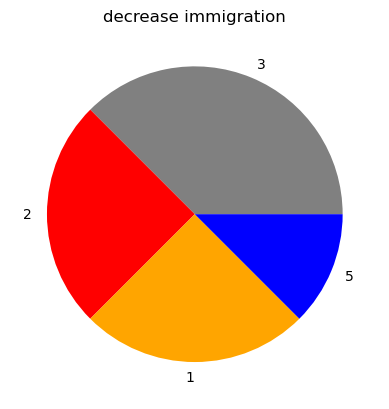

In [18]:
create_plot("decrease immigration")

## good/bad

,level of agreement,number of agents
0,5,12
1,4,3


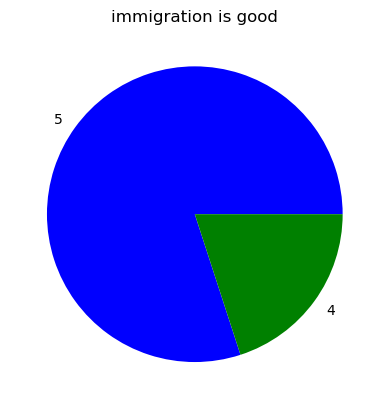

In [19]:
create_plot("immigration is good")

,level of agreement,number of agents
0,3,3
1,5,3
2,1,2


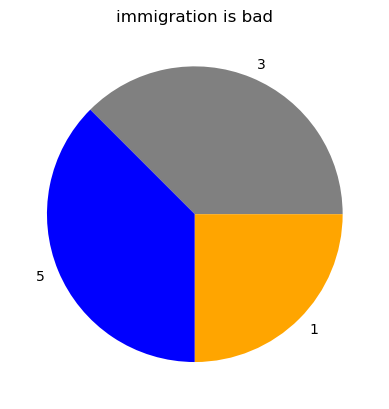

In [20]:
create_plot("immigration is bad")

## 4) climate chagne

### important/not important

,level of agreement,number of agents
0,5,18


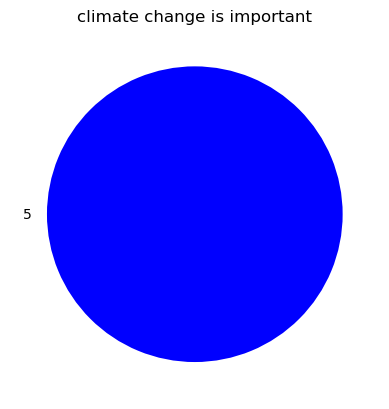

In [21]:
create_plot("climate change is important")

,level of agreement,number of agents
0,1,6
1,5,6
2,3,4


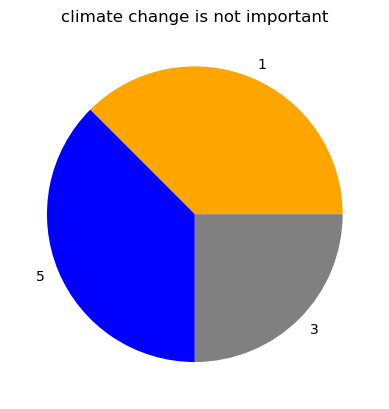

In [22]:
create_plot("climate change is not important")

### real/not real

,level of agreement,number of agents
0,5,16


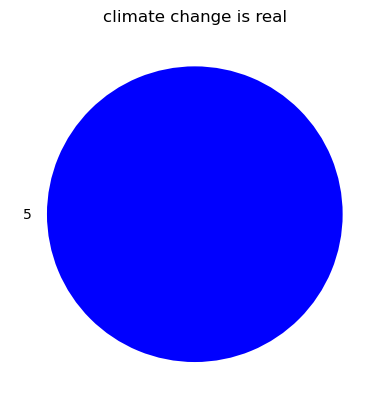

In [23]:
create_plot("climate change is real")

,level of agreement,number of agents
0,1,7
1,5,5


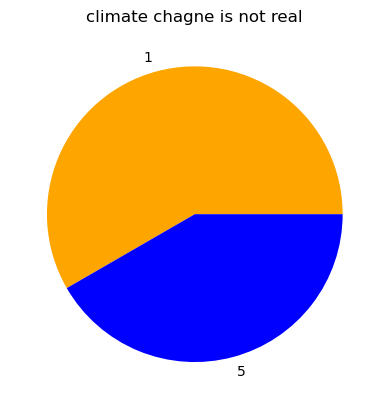

In [24]:
create_plot('climate chagne is not real')

## 5) women in positions of combat 

### allowed/not allowed

,level of agreement,number of agents
0,5,19


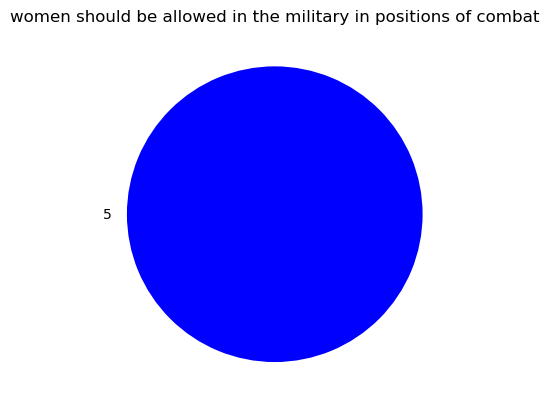

In [25]:
create_plot("women should be allowed in the military in positions of combat")

,level of agreement,number of agents
0,1,5
1,5,4
2,3,2


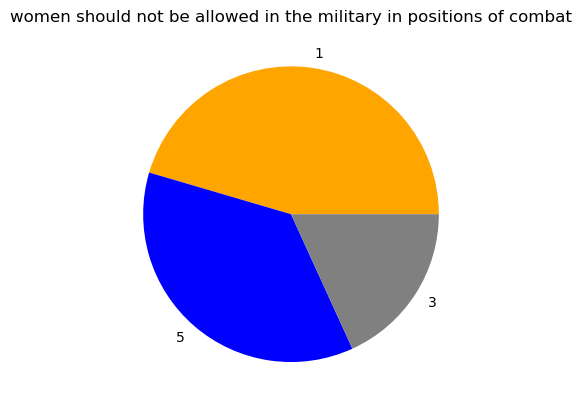

In [26]:
create_plot("women should not be allowed in the military in positions of combat")

### good/bad

,level of agreement,number of agents
0,5,16


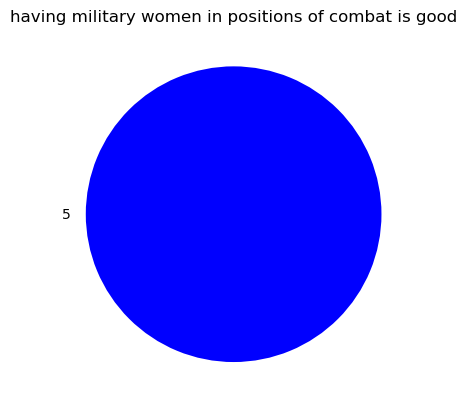

In [27]:
create_plot("having military women in positions of combat is good")

,level of agreement,number of agents
0,5,7
1,1,6
2,3,1


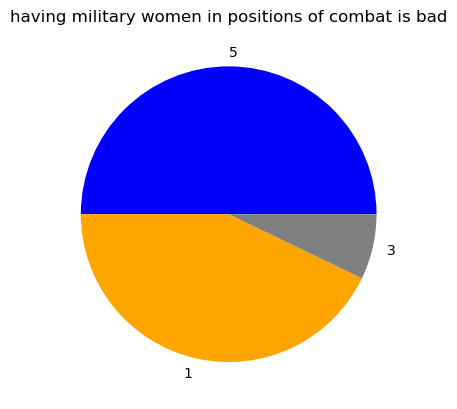

In [28]:
create_plot("having military women in positions of combat is bad")

## 6) LGBTQ rights

### improved/not needed to improve

,level of agreement,number of agents
0,5,17
1,4,1


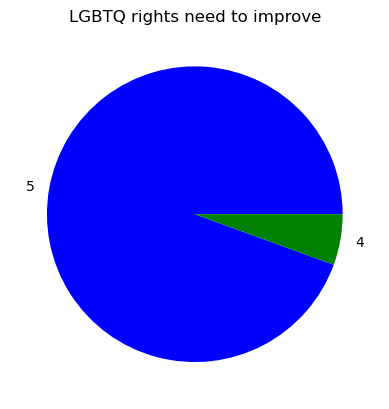

In [29]:
create_plot("LGBTQ rights need to improve")

,level of agreement,number of agents
0,5,15


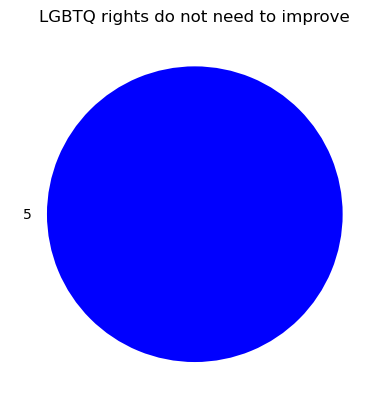

In [30]:
create_plot("LGBTQ rights do not need to improve")

## 7) abortion

### allowed/banned

,level of agreement,number of agents
0,5,12
1,4,1


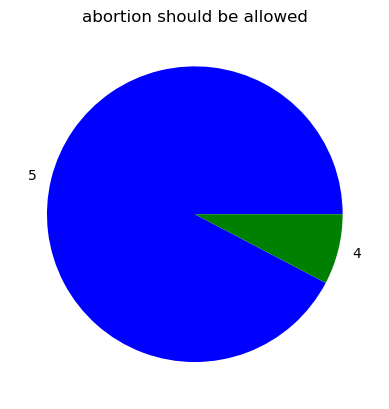

In [33]:
create_plot("abortion should be allowed")

,level of agreement,number of agents
0,5,8
1,3,5


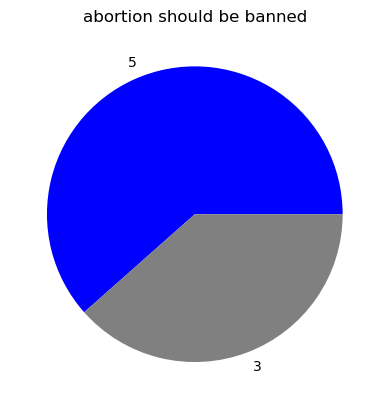

In [34]:
create_plot("abortion should be banned")

## 8) affirmative action

### should practice/banned

,level of agreement,number of agents
0,5,13
1,3,2
2,4,2


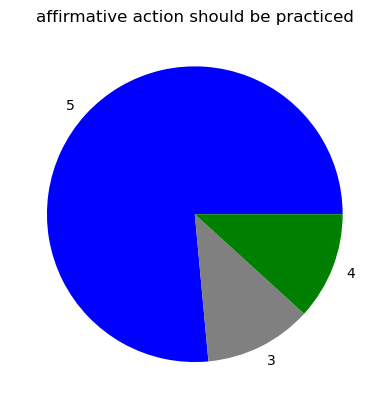

In [35]:
create_plot("affirmative action should be practiced")

,level of agreement,number of agents
0,3,7
1,5,7
2,2,1
3,4,1


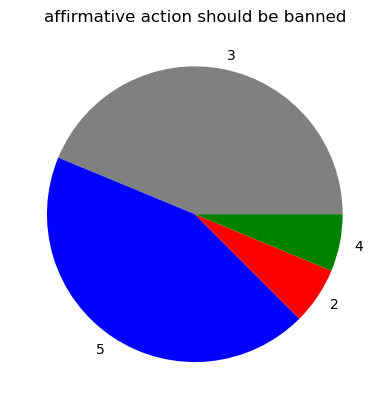

In [36]:
create_plot("affirmative action should be banned")

### good/bad

,level of agreement,number of agents
0,5,11
1,4,5
2,3,2


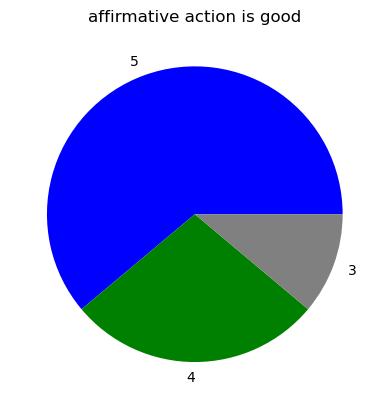

In [37]:
create_plot("affirmative action is good")

,level of agreement,number of agents
0,3,8
1,5,3
2,1,3
3,2,1


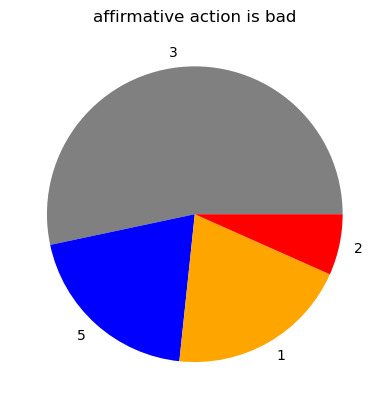

In [38]:
create_plot("affirmative action is bad")

## 9) marijuana

### legalized/banned

,level of agreement,number of agents
0,5,13


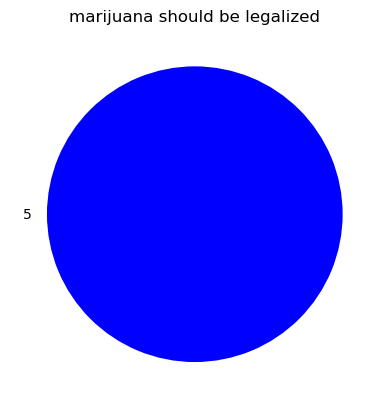

In [39]:
create_plot("marijuana should be legalized")

,level of agreement,number of agents
0,3,8
1,5,3
2,1,1


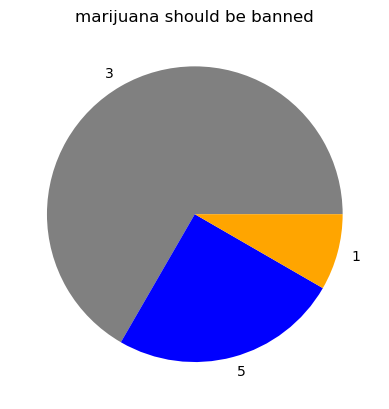

In [40]:
create_plot("marijuana should be banned")

### good/bad

,level of agreement,number of agents
0,5,4
1,4,3
2,3,2


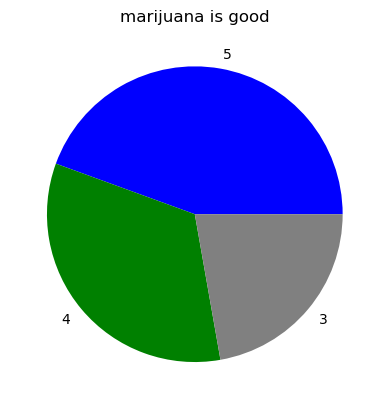

In [41]:
create_plot("marijuana is good")

,level of agreement,number of agents
0,3,5
1,5,4
2,1,1


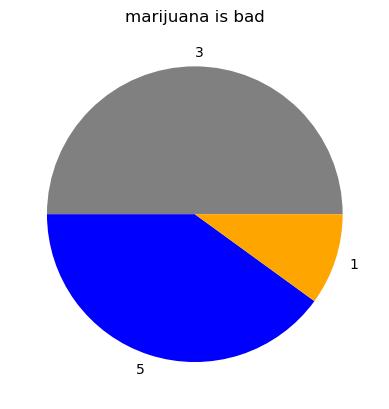

In [42]:
create_plot("marijuana is bad")

## 10) student loan interest rates 

### increased/decreased

,level of agreement,number of agents
0,3,8
1,1,4
2,5,3


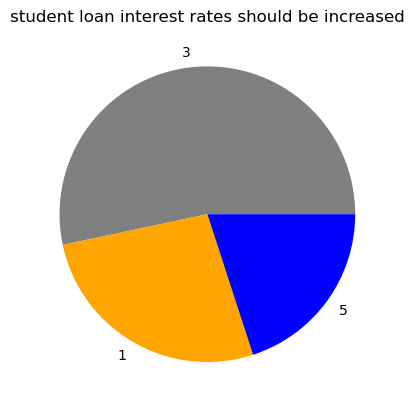

In [43]:
create_plot("student loan interest rates should be increased")

,level of agreement,number of agents
0,5,16
1,3,1


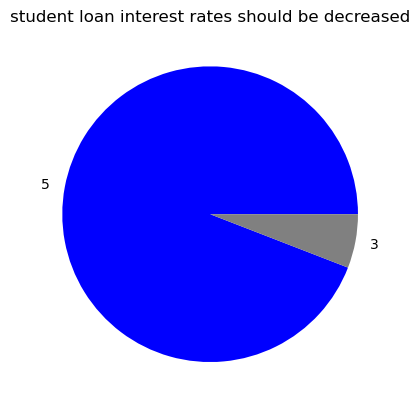

In [44]:
create_plot("student loan interest rates should be decreased")

### good/bad

,level of agreement,number of agents
0,5,9
1,3,7
2,2,3


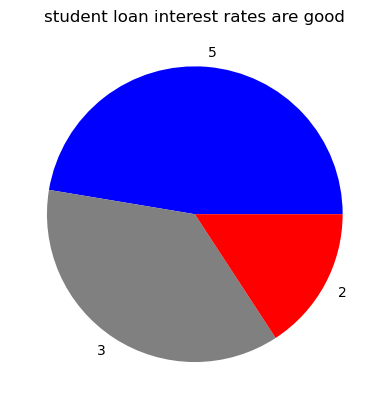

In [45]:
create_plot("student loan interest rates are good")

,level of agreement,number of agents
0,5,16
1,4,1


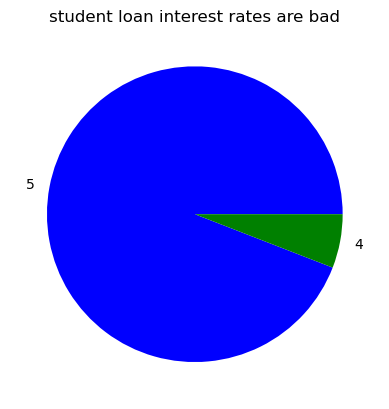

In [46]:
create_plot("student loan interest rates are bad")

## Conclusions

- The model is NOT biased towards always agreeing. Most of the time, if the model mostly agrees with a statement, the portion of agents that agree with the opposite statment is MUCH smaller.
- The model MIGHT BE biased towards neutrality. Although fewer agents will agree with the opposite statment, the majority will still be neutral, not disagree. 
- It seems that it there is no clear winner in deciding between using political language vs. using simple language. 